<a href="https://colab.research.google.com/github/RISHI311005/data_engineering/blob/main/dataengineeringIA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# --------------------
# STEP 1: EXTRACT
# --------------------
print("Extracting data from CSV files...")

# Load data from CSV files
#product_df = pd.read_csv("product_info.csv")
sales_df = pd.read_csv("statsfinal.csv")




Extracting data from CSV files...


In [ ]:
import pandas as pd


print("Extracting data...\n")

# Sample product data
product_data = {
    'product_id': [1, 2, 3],
    'product_name': ['Apples', 'Bananas', 'Oranges'],
    'category': ['Fruit', 'Fruit', 'Fruit']
}
product_df = pd.DataFrame(product_data)

# Sample sales data
sales_data = {
    'product_id': [1, 2, 3],
    'sales_month_1': [120, 150, 100],
    'sales_month_2': [130, 160, 110],
    'sales_month_3': [140, 170, 120],
    'sales_month_4': [150, 180, 130],
    'sales_month_5': [160, 190, 140],
    'sales_month_6': [170, 200, 150],
    'sales_month_7': [180, 210, 160],
    'sales_month_8': [190, 220, 170],
    'sales_month_9': [200, 230, 180],
    'sales_month_10': [210, 240, 190],
    'sales_month_11': [220, 250, 200],
    'sales_month_12': [230, 260, 210],
}
sales_df = pd.DataFrame(sales_data)

# --------------------
# STEP 2: TRANSFORM
# --------------------
print("Transforming data...\n")

# Strip whitespace from column names
sales_df.columns = sales_df.columns.str.strip()

# Get list of monthly sales columns
monthly_columns = [f'sales_month_{i}' for i in range(1, 13)]

# Check for missing columns
missing_cols = [col for col in monthly_columns if col not in sales_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in sales_df: {missing_cols}")

# Calculate total yearly sales
sales_df['total_sales'] = sales_df[monthly_columns].sum(axis=1)

# Merge dataframes on product_id
merged_df = pd.merge(product_df, sales_df, on='product_id')

# Display transformation summary
print("=== Transformation Summary ===")
print(f"Original products count: {len(product_df)}")
print(f"Original sales records count: {len(sales_df)}")
print(f"Merged dataset count: {len(merged_df)}\n")

# Show sample of the transformed data
print("=== Sample Transformed Data ===")
print(merged_df.head())



Extracting data...

Transforming data...

=== Transformation Summary ===
Original products count: 3
Original sales records count: 3
Merged dataset count: 3

=== Sample Transformed Data ===
   product_id product_name category  sales_month_1  sales_month_2  \
0           1       Apples    Fruit            120            130   
1           2      Bananas    Fruit            150            160   
2           3      Oranges    Fruit            100            110   

   sales_month_3  sales_month_4  sales_month_5  sales_month_6  sales_month_7  \
0            140            150            160            170            180   
1            170            180            190            200            210   
2            120            130            140            150            160   

   sales_month_8  sales_month_9  sales_month_10  sales_month_11  \
0            190            200             210             220   
1            220            230             240             250   
2           

In [ ]:
# --------------------
# STEP 3: LOAD
# --------------------
import sqlite3
from datetime import datetime

print("Loading data into SQLite data warehouse...\n")

# Create database connection
db_path = "sales_warehouse.db"
try:
    conn = sqlite3.connect(db_path)

    # Create a timestamp for the load
    load_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Add load timestamp to the data
    merged_df['load_timestamp'] = load_timestamp

    # Load data into SQLite
    merged_df.to_sql(
        name='product_sales',      # Table name
        con=conn,                 # Database connection
        if_exists='replace',      # Options: 'fail', 'replace', 'append'
        index=False,              # Don't write DataFrame index
        dtype={
            'product_id': 'TEXT PRIMARY KEY',
            'total_sales': 'REAL',
            'load_timestamp': 'TEXT'
        }
    )

    # Verify load
    loaded_count = pd.read_sql("SELECT COUNT(*) FROM product_sales", conn).iloc[0,0]

    print("=== Load Summary ===")
    print(f"Database path: {db_path}")
    print(f"Table created: product_sales")
    print(f"Records loaded: {loaded_count}")
    print(f"Load timestamp: {load_timestamp}\n")

except Exception as e:
    print(f"Error loading data: {str(e)}")

finally:
    # Close connection
    if 'conn' in locals():
        conn.close()
    print("Load process completed.")


Loading data into SQLite data warehouse...

=== Load Summary ===
Database path: sales_warehouse.db
Table created: product_sales
Records loaded: 3
Load timestamp: 2025-04-10 14:03:25

Load process completed.


In [ ]:
import pandas as pd
conn = sqlite3.connect("sales_warehouse.db")
print(pd.read_sql("SELECT * FROM product_sales LIMIT 5", conn))
conn.close()

  product_id product_name category  sales_month_1  sales_month_2  \
0          1       Apples    Fruit            120            130   
1          2      Bananas    Fruit            150            160   
2          3      Oranges    Fruit            100            110   

   sales_month_3  sales_month_4  sales_month_5  sales_month_6  sales_month_7  \
0            140            150            160            170            180   
1            170            180            190            200            210   
2            120            130            140            150            160   

   sales_month_8  sales_month_9  sales_month_10  sales_month_11  \
0            190            200             210             220   
1            220            230             240             250   
2            170            180             190             200   

   sales_month_12  total_sales       load_timestamp  
0             230       2100.0  2025-04-10 14:03:25  
1             260       2460.

In [ ]:
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError
import pandas as pd
from datetime import datetime
import time

def test_connection(engine, max_retries=3, delay=2):
    """Test database connection with retries"""
    for attempt in range(max_retries):
        try:
            with engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            return True
        except OperationalError as e:
            if attempt < max_retries - 1:
                print(f"Connection failed (attempt {attempt + 1}/{max_retries}), retrying...")
                time.sleep(delay)
                continue
            raise ConnectionError(f"Could not connect to database after {max_retries} attempts. Error: {str(e)}")

def transform_data(product_df, sales_df):
    """Transform and merge product and sales data"""
    print("Transforming data...\n")

    # Calculate total sales across months
    if any(col.startswith('sales_month_') for col in sales_df.columns):
        sales_df['total_sales'] = sales_df.loc[:, 'sales_month_1':'sales_month_12'].sum(axis=1)

    # Merge datasets on product_id
    merged_df = pd.merge(product_df, sales_df, on='product_id')

    # Add load timestamp
    merged_df['load_timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    print("=== Transformation Complete ===")
    print(merged_df.head())
    return merged_df

def load_to_dwh(df_dict, db_config):
    """Load data to SQLite data warehouse"""
    engine = None
    try:
        db_type = db_config["type"]

        if db_type == "sqlite":
            db_path = db_config["database"]
            engine = create_engine(f"sqlite:///{db_path}")
        else:
            raise ValueError("Only SQLite is supported in this version.")

        print("Testing database connection...")
        test_connection(engine)

        with engine.begin() as conn:
            for table_name, (df, pk) in df_dict.items():
                print(f"Loading {table_name} ({len(df)} rows)...")
                df.to_sql(
                    name=table_name,
                    con=conn,
                    if_exists="replace",
                    index=False,
                    chunksize=1000
                )

        with engine.connect() as conn:
            print("\n=== LOAD SUCCESS ===")
            print(f"Database: {db_config['database']}")
            print(f"Timestamp: {datetime.now().isoformat()}")
            for table in df_dict:
                count = conn.execute(text(f"SELECT COUNT(*) FROM {table}")).scalar()
                print(f"- {table}: {count} records")

    except Exception as e:
        print(f"\nLOAD FAILED: {str(e)}")
    finally:
        if engine:
            engine.dispose()


# ---------------------
# 🚀 RUN THIS SECTION
# ---------------------
if __name__ == "__main__":
    # Expanded product list with 4 products
    product_df = pd.DataFrame({
        'product_id': ['p1', 'p2', 'p3', 'p4'],
        'name': ['Product 1', 'Product 2', 'Product 3', 'Product 4']
    })

    # Expanded sales data for 4 products
    sales_df = pd.DataFrame({
        'product_id': ['p1', 'p2', 'p3', 'p4'],
        'sales_month_1': [10, 20, 15, 5],
        'sales_month_2': [5, 15, 12, 6],
        'sales_month_3': [12, 18, 10, 7],
        'sales_month_4': [7, 14, 11, 8],
        'sales_month_5': [11, 9, 13, 5],
        'sales_month_6': [13, 8, 14, 4],
        'sales_month_7': [6, 11, 12, 6],
        'sales_month_8': [14, 13, 10, 9],
        'sales_month_9': [9, 10, 8, 5],
        'sales_month_10': [15, 12, 9, 6],
        'sales_month_11': [8, 7, 6, 5],
        'sales_month_12': [10, 6, 7, 4],
    })

    # Transform and merge product + sales
    merged_df = transform_data(product_df, sales_df)

    # SQLite config
    db_config = {
        "type": "sqlite",
        "database": "walmart_dwh.db"
    }

    data_to_load = {
        "product_sales": (merged_df, "product_id")
    }

    # Load the merged result into SQLite
    load_to_dwh(data_to_load, db_config)


Transforming data...

=== Transformation Complete ===
  product_id       name  sales_month_1  sales_month_2  sales_month_3  \
0         p1  Product 1             10              5             12   
1         p2  Product 2             20             15             18   
2         p3  Product 3             15             12             10   
3         p4  Product 4              5              6              7   

   sales_month_4  sales_month_5  sales_month_6  sales_month_7  sales_month_8  \
0              7             11             13              6             14   
1             14              9              8             11             13   
2             11             13             14             12             10   
3              8              5              4              6              9   

   sales_month_9  sales_month_10  sales_month_11  sales_month_12  total_sales  \
0              9              15               8              10          120   
1             10      

<ipython-input-7-b1c48ac3caa8>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_sales, x="name", y="total_sales", palette="viridis")


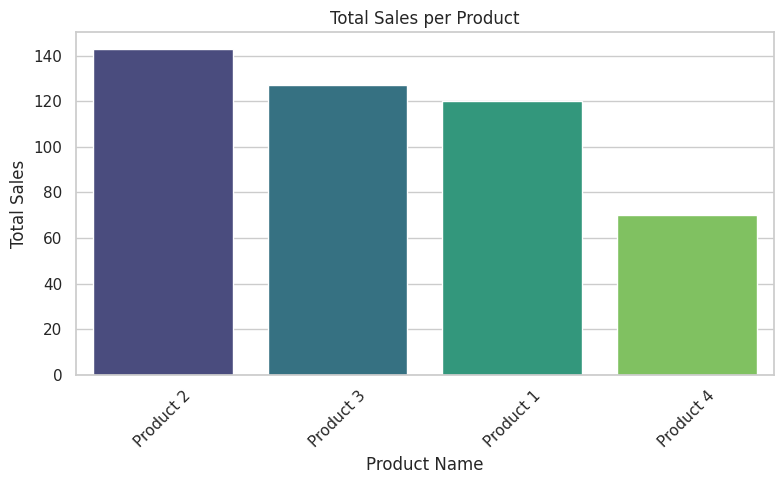

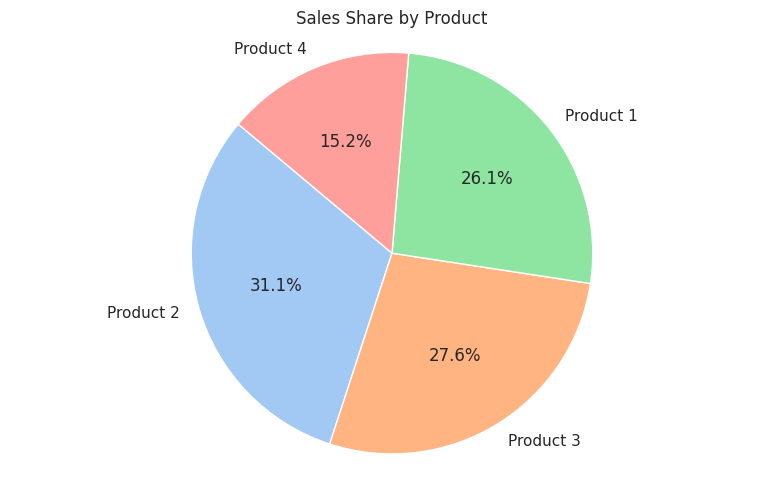

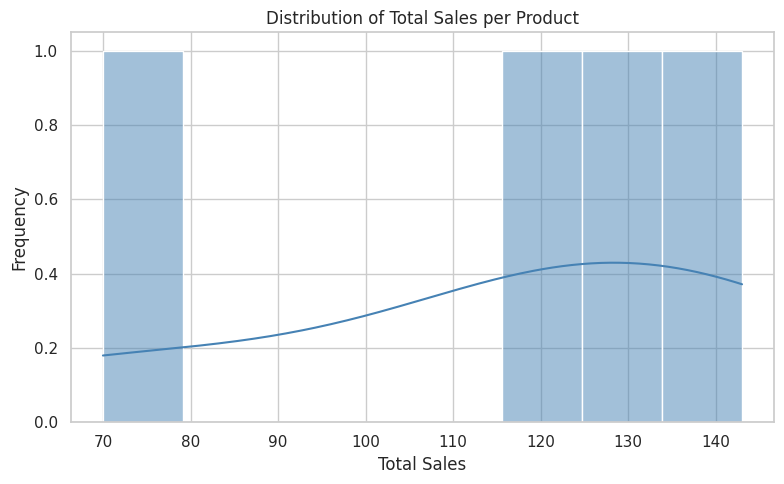

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# -----------------------------
# Connect to SQLite Database
# -----------------------------
engine = create_engine("sqlite:///walmart_dwh.db")

# -----------------------------
# Load product_sales table
# -----------------------------
df = pd.read_sql("SELECT * FROM product_sales", engine)

# -----------------------------
# 1. Bar Chart - Total Sales per Product
# -----------------------------
total_sales = df[["name", "total_sales"]].sort_values(by="total_sales", ascending=False)

sns.barplot(data=total_sales, x="name", y="total_sales", palette="viridis")
plt.title("Total Sales per Product")
plt.xlabel("Product Name")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Pie Chart - Sales Share by Product
# -----------------------------
plt.pie(
    total_sales["total_sales"],
    labels=total_sales["name"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("pastel")
)
plt.title("Sales Share by Product")
plt.axis("equal")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Histogram - Distribution of Total Sales
# -----------------------------
sns.histplot(df["total_sales"], bins=8, kde=True, color="steelblue")
plt.title("Distribution of Total Sales per Product")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
